In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import os
import math
from tqdm import tqdm
from torch.utils.data import DataLoader

In [2]:
class MyRnn(nn.Module):
  def __init__(self, in_d=2, out_d=2, hidden_d=4, num_hidden=1):
    super(MyRnn, self).__init__()
    self.lstm = nn.RNN(input_size=in_d, hidden_size=hidden_d, num_layers=num_hidden)
    self.lstm2 = nn.RNN(input_size=hidden_d, hidden_size=hidden_d, num_layers=num_hidden)
    self.fc = nn.Linear(hidden_d, out_d)

  def forward(self, x, h0):
    r, h = self.lstm(x, h0)
    r2, h2 = self.lstm2(r, h)
    y = self.fc(r2)  # no activation on the output
    return y, h

In [3]:
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, path_dir, map_file, transform=None, shape = (100,100), device='cpu'):
        self.device = device
        self.paths = [] # create a list to hold all paths read from file
        # self.map = np.loadtxt(map_file, skiprows=2).reshape(shape)
        # self.map = self.map[np.newaxis, :, :]
        x = torch.tensor([]) # empty list to hold input series tensors
        num_paths = 0
        for filename in tqdm(os.listdir(path_dir)):
            num_paths += 1
            with open(os.path.join(path_dir, filename), 'r') as f: # open in readonly mode
                path_points_list = [] # a list to hold each point in a path
                self.flat_path = np.loadtxt(f) # load in the flat path from file
                self.path = np.asarray(self.flat_path, dtype=np.float32).reshape(len(self.flat_path)//2,2) #unflatten the path from the file
                # print(self.path)
                for point in self.path:
                    x = point[0]
                    y = point[1]
                    this_point = [x, y]
                    path_points_list.append(this_point)
            sequence = torch.tensor(path_points_list, dtype=torch.float)[:, None, :]
            self.paths.append(sequence)
                # self.path_tensor = self.convert_path(shape, self.path)

        # self.sequences = []
        # for path in range(len(path_list)):
        #    self.sequences.append((path_list[path] - mu)/sig)
        
        self.transform = transform
        print("Done!")

    def convert_path(self, map_dim, path):
        path_mat = np.zeros(map_dim, dtype=float)

        # Make the path continuous
        for i in range(path.shape[0] - 1):
            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            if (x1 < x2):
                x_dir = 1
            else:
                x_dir = -1

            if (y1 < y2):
                y_dir = 1
            else:
                y_dir = -1

            # Determine y from x
            if x2-x1 != 0:
                m = (y2-y1)/(x2-x1)
                while x != x2:
                    y = round(m*(x-x1) + y1)
                    path_mat[y,x] = 1
                    x += x_dir
            else:
                while x != x2:
                    path_mat[y1,x] = 1
                    x += x_dir


            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            # Determine x from y
            if y2-y1 != 0:
                m = (x2-x1)/(y2-y1)
                while y != y2:
                    x = round(m*(y-y1) + x1)
                    path_mat[y,x] = 1
                    y += y_dir
            else:
                while y != y2:
                    path_mat[y,x1] = 1
                    y += y_dir

        # print(path)
        # print(f'xs: {path[:,0]}')
        # print(f'ys: {path[:,1]}')
        # path_tensor = torch.tensor(path)
        # print(path_tensor)
        return path

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # x = np.float32(self.sequences[idx])
        # x = torch.Tensor(x).to(self.device)

        x = self.paths[idx]
        if self.transform:
            x = self.transform(x)
        
        return x

        #return image, label

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dataset name
MAP_NAME = '8x12_map_cropped'
DATASET = 'random_paths'
MAP_SHAPE = (64,64)
# training parameters
BATCH_SIZE = 32
train_dataset = PathsDataset(path_dir = f"./env/{MAP_NAME}/paths/{DATASET}/small_2000", map_file = f"./env/{MAP_NAME}/{MAP_NAME}.txt", shape = MAP_SHAPE, transform=None, device=device)
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 1991/1991 [00:00<00:00, 4573.20it/s]

Done!


In [5]:
x = torch.cat(train_dataset[:], dim=0)
print(x.shape)
mu = x.mean(dim=0)
sig=x.std(dim=0)
sequences = []
for i in range(len(train_dataset)):
    sequences.append((train_dataset[i]-mu)/sig)


torch.Size([22559, 1, 2])


In [6]:
# mu = x.mean(dim=0)
# sig=x.std(dim=0)
# sequences = [(s0-mu)/sig, (s1-mu)/sig, (s2-mu)/sig, (s3-mu)/sig, (s4-mu)/sig, (s5-mu)/sig, (s6-mu)/sig, (s7-mu)/sig, (s8-mu)/sig, (s9-mu)/sig, (s10-mu)/sig]  # pythonic list to hold sequences of un-even length

  0%|          | 0/5 [00:00<?, ?it/s]

pred shape: torch.Size([10, 1, 2])
pred shape: torch.Size([9, 1, 2])
pred shape: torch.Size([11, 1, 2])
pred shape: torch.Size([5, 1, 2])
pred shape: torch.Size([6, 1, 2])
pred shape: torch.Size([11, 1, 2])
pred shape: torch.Size([5, 1, 2])
pred shape: torch.Size([7, 1, 2])
pred shape: torch.Size([27, 1, 2])
pred shape: torch.Size([9, 1, 2])
pred shape: torch.Size([13, 1, 2])
pred shape: torch.Size([15, 1, 2])
pred shape: torch.Size([11, 1, 2])
pred shape: torch.Size([6, 1, 2])
pred shape: torch.Size([1, 1, 2])
pred shape: torch.Size([3, 1, 2])
pred shape: torch.Size([13, 1, 2])
pred shape: torch.Size([7, 1, 2])
pred shape: torch.Size([4, 1, 2])
pred shape: torch.Size([4, 1, 2])
pred shape: torch.Size([8, 1, 2])
pred shape: torch.Size([13, 1, 2])
pred shape: torch.Size([3, 1, 2])
pred shape: torch.Size([17, 1, 2])
pred shape: torch.Size([15, 1, 2])
pred shape: torch.Size([12, 1, 2])
pred shape: torch.Size([3, 1, 2])
pred shape: torch.Size([15, 1, 2])
pred shape: torch.Size([11, 1, 2])


 20%|██        | 1/5 [00:02<00:09,  2.32s/it]

pred shape: torch.Size([8, 1, 2])
pred shape: torch.Size([4, 1, 2])
pred shape: torch.Size([8, 1, 2])
pred shape: torch.Size([12, 1, 2])
pred shape: torch.Size([3, 1, 2])
pred shape: torch.Size([17, 1, 2])
pred shape: torch.Size([7, 1, 2])
pred shape: torch.Size([14, 1, 2])
pred shape: torch.Size([9, 1, 2])
pred shape: torch.Size([15, 1, 2])
pred shape: torch.Size([8, 1, 2])
pred shape: torch.Size([12, 1, 2])
pred shape: torch.Size([9, 1, 2])
pred shape: torch.Size([15, 1, 2])
pred shape: torch.Size([20, 1, 2])
pred shape: torch.Size([5, 1, 2])
pred shape: torch.Size([16, 1, 2])
pred shape: torch.Size([4, 1, 2])
pred shape: torch.Size([10, 1, 2])
pred shape: torch.Size([8, 1, 2])
pred shape: torch.Size([2, 1, 2])
pred shape: torch.Size([10, 1, 2])
pred shape: torch.Size([9, 1, 2])
pred shape: torch.Size([6, 1, 2])
pred shape: torch.Size([3, 1, 2])
pred shape: torch.Size([11, 1, 2])
pred shape: torch.Size([2, 1, 2])
pred shape: torch.Size([3, 1, 2])
pred shape: torch.Size([16, 1, 2])
pr

 40%|████      | 2/5 [00:04<00:06,  2.30s/it]

pred shape: torch.Size([5, 1, 2])
pred shape: torch.Size([2, 1, 2])
pred shape: torch.Size([7, 1, 2])
pred shape: torch.Size([14, 1, 2])
pred shape: torch.Size([16, 1, 2])
pred shape: torch.Size([5, 1, 2])
pred shape: torch.Size([5, 1, 2])
pred shape: torch.Size([3, 1, 2])
pred shape: torch.Size([1, 1, 2])
pred shape: torch.Size([17, 1, 2])
pred shape: torch.Size([15, 1, 2])
pred shape: torch.Size([10, 1, 2])
pred shape: torch.Size([7, 1, 2])
pred shape: torch.Size([12, 1, 2])
pred shape: torch.Size([11, 1, 2])
pred shape: torch.Size([14, 1, 2])
pred shape: torch.Size([15, 1, 2])
pred shape: torch.Size([14, 1, 2])
pred shape: torch.Size([16, 1, 2])
pred shape: torch.Size([12, 1, 2])
pred shape: torch.Size([12, 1, 2])
pred shape: torch.Size([8, 1, 2])
pred shape: torch.Size([5, 1, 2])
pred shape: torch.Size([24, 1, 2])
pred shape: torch.Size([10, 1, 2])
pred shape: torch.Size([16, 1, 2])
pred shape: torch.Size([10, 1, 2])
pred shape: torch.Size([15, 1, 2])
pred shape: torch.Size([13, 1,

 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

pred shape: torch.Size([9, 1, 2])
pred shape: torch.Size([15, 1, 2])
pred shape: torch.Size([8, 1, 2])
pred shape: torch.Size([12, 1, 2])
pred shape: torch.Size([9, 1, 2])
pred shape: torch.Size([15, 1, 2])
pred shape: torch.Size([20, 1, 2])
pred shape: torch.Size([5, 1, 2])
pred shape: torch.Size([16, 1, 2])
pred shape: torch.Size([4, 1, 2])
pred shape: torch.Size([10, 1, 2])
pred shape: torch.Size([8, 1, 2])
pred shape: torch.Size([2, 1, 2])
pred shape: torch.Size([10, 1, 2])
pred shape: torch.Size([9, 1, 2])
pred shape: torch.Size([6, 1, 2])
pred shape: torch.Size([3, 1, 2])
pred shape: torch.Size([11, 1, 2])
pred shape: torch.Size([2, 1, 2])
pred shape: torch.Size([3, 1, 2])
pred shape: torch.Size([16, 1, 2])
pred shape: torch.Size([10, 1, 2])
pred shape: torch.Size([17, 1, 2])
pred shape: torch.Size([8, 1, 2])
pred shape: torch.Size([11, 1, 2])
pred shape: torch.Size([14, 1, 2])
pred shape: torch.Size([12, 1, 2])
pred shape: torch.Size([1, 1, 2])
pred shape: torch.Size([9, 1, 2])


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

pred shape: torch.Size([14, 1, 2])
pred shape: torch.Size([16, 1, 2])
pred shape: torch.Size([12, 1, 2])
pred shape: torch.Size([12, 1, 2])
pred shape: torch.Size([8, 1, 2])
pred shape: torch.Size([5, 1, 2])
pred shape: torch.Size([24, 1, 2])
pred shape: torch.Size([10, 1, 2])
pred shape: torch.Size([16, 1, 2])
pred shape: torch.Size([10, 1, 2])
pred shape: torch.Size([15, 1, 2])
pred shape: torch.Size([13, 1, 2])
pred shape: torch.Size([9, 1, 2])
pred shape: torch.Size([9, 1, 2])
pred shape: torch.Size([3, 1, 2])
pred shape: torch.Size([11, 1, 2])
pred shape: torch.Size([17, 1, 2])
pred shape: torch.Size([14, 1, 2])
pred shape: torch.Size([11, 1, 2])
pred shape: torch.Size([16, 1, 2])
pred shape: torch.Size([8, 1, 2])
pred shape: torch.Size([12, 1, 2])
pred shape: torch.Size([4, 1, 2])
pred shape: torch.Size([24, 1, 2])
pred shape: torch.Size([32, 1, 2])
pred shape: torch.Size([12, 1, 2])
pred shape: torch.Size([12, 1, 2])
pred shape: torch.Size([6, 1, 2])
pred shape: torch.Size([8, 1

100%|██████████| 5/5 [00:11<00:00,  2.30s/it]

pred shape: torch.Size([9, 1, 2])
pred shape: torch.Size([6, 1, 2])
pred shape: torch.Size([3, 1, 2])
pred shape: torch.Size([11, 1, 2])
pred shape: torch.Size([2, 1, 2])
pred shape: torch.Size([3, 1, 2])
pred shape: torch.Size([16, 1, 2])
pred shape: torch.Size([10, 1, 2])
pred shape: torch.Size([17, 1, 2])
pred shape: torch.Size([8, 1, 2])
pred shape: torch.Size([11, 1, 2])
pred shape: torch.Size([14, 1, 2])
pred shape: torch.Size([12, 1, 2])
pred shape: torch.Size([1, 1, 2])
pred shape: torch.Size([9, 1, 2])
pred shape: torch.Size([11, 1, 2])
pred shape: torch.Size([4, 1, 2])
pred shape: torch.Size([15, 1, 2])
pred shape: torch.Size([6, 1, 2])


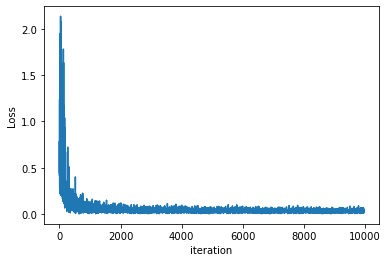

In [7]:
in_d = train_dataset[0].shape[-1]
out_d = in_d
hidden_d = 8
num_hidden = 1
rnn = MyRnn(in_d, out_d, hidden_d, num_hidden)
loss = []
criterion = nn.MSELoss()
opt = torch.optim.SGD(rnn.parameters(), lr=0.01)
# n_epochs = 1000
n_epochs = 5
for e in trange(n_epochs):
  for s in sequences:
    pred, _ = rnn(s[:-1,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # predict next step, init hidden state to zero at the begining of the sequence
    print(f'pred shape: {pred.shape}')
    err = criterion(pred, s[1:, ...])  # predict next step for each step
    opt.zero_grad()
    err.backward()
    opt.step()
    loss.append(err.item())
    if s % 100 is 0:  
      print(err.item())
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

In [8]:
paths = []
pred_points = []
actual_points = []
training_points = []
rnn.eval()
with torch.no_grad():
  k = 20
  for si, s in enumerate(sequences[1:30]):
    pred_xs = []
    pred_ys = []
    actual_xs = []
    actual_ys = []
    training_xs = []
    training_ys = []

    pred, h = rnn(s[:k,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # given first k steps predict the next one
    try:
      print('seq {}, prev = {}  -> predicted {}th step = {}, actual step = {}'.format(si, s[k-1,...]*sig+mu, k, pred[-1, ...]*sig + mu, s[k, ...]*sig+mu))
    except:
      pass
    prev = (torch.round(pred[-1:, ...]*sig + mu) - mu) / sig  # round the prediction, attmepting to avoid accumulation of error

    for j in  range(0, k):
      try:
        training_xs.append((s[j, ...]*sig + mu).cpu().detach().numpy()[0][0])
        training_ys.append((s[j, ...]*sig + mu).cpu().detach().numpy()[0][1])
      except:
        pass
      
    # continue to predict 
    for j in  range(k+1, s.shape[0]):
      pred, h = rnn(prev, h)
      print('\t\tpredicted step {} (prev = {}) = {}, actual step = {}'.format(j, prev*sig+mu, pred[-1,...]*sig+mu, s[j, ...]*sig + mu))
      prev = (torch.round(pred*sig + mu) - mu) / sig

      # predicted points
      pred_xs.append((pred[-1,...]*sig+mu).cpu().detach().numpy()[0][0])
      pred_ys.append((pred[-1,...]*sig+mu).cpu().detach().numpy()[0][1])

      # actual points
      actual_xs.append((s[j, ...]*sig + mu).cpu().detach().numpy()[0][0])
      actual_ys.append((s[j, ...]*sig + mu).cpu().detach().numpy()[0][1])


      
    actual_points.append([actual_xs, actual_ys])
    pred_points.append([pred_xs, pred_ys])
    training_points.append([training_xs, training_ys])
      # actual_points.append((s[j, ...]*sig + mu).detach().cpu().numpy())
  print('\n')

seq 7, prev = tensor([[21., 22.]])  -> predicted 20th step = tensor([[19.9078, 24.2129]]), actual step = tensor([[21., 26.]])
		predicted step 21 (prev = tensor([[[20., 24.]]])) = tensor([[21.1570, 24.2355]]), actual step = tensor([[18., 28.]])
		predicted step 22 (prev = tensor([[[21., 24.]]])) = tensor([[22.4550, 23.4143]]), actual step = tensor([[16.0000, 31.0000]])
		predicted step 23 (prev = tensor([[[22., 23.]]])) = tensor([[22.8672, 22.2046]]), actual step = tensor([[15.0000, 35.0000]])
		predicted step 24 (prev = tensor([[[23., 22.]]])) = tensor([[23.7278, 21.3737]]), actual step = tensor([[19., 38.]])
		predicted step 25 (prev = tensor([[[24., 21.]]])) = tensor([[24.5116, 20.6295]]), actual step = tensor([[16.0000, 41.0000]])
		predicted step 26 (prev = tensor([[[25., 21.]]])) = tensor([[25.3216, 21.0750]]), actual step = tensor([[13., 43.]])
		predicted step 27 (prev = tensor([[[25., 21.]]])) = tensor([[24.9225, 20.9435]]), actual step = tensor([[11., 46.]])




In [9]:
# pred_points

In [10]:
# actual_points

In [11]:
# pred_points[0][1]

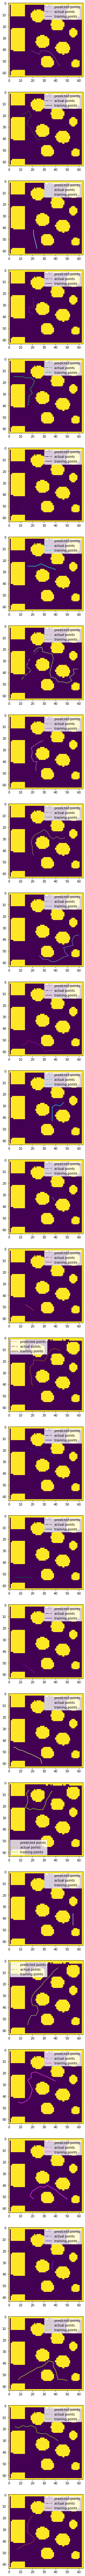

<Figure size 432x288 with 0 Axes>

In [12]:
from cProfile import label
from random import random
from turtle import color


flat_map = np.loadtxt("./env/8x12_map_cropped/8x12_map_cropped.txt", skiprows=2)
map = np.asarray(flat_map).reshape(64,64)

# fig = plt.figure(figsize=(10,10))
# fig, ax = plt.subplots(nrows=30, ncols=1)

# ax = fig.add_subplot(111)

# plt.xlim([0,64])
# plt.ylim([0,64])
# ax.set_aspect('equal', adjustable='box')
# for x in ax:
#     colorR=random()
#     colorG=random()
#     colorB=random()
#     x.plot(pred_points[x][0], pred_points[x][1], color=(colorR, colorG, colorB), linestyle='dotted')
#     x.plot(actual_points[x][0], actual_points[x][1], color=(colorR, colorG, colorB), linestyle='dashdot')
#     x.plot(training_points[x][0], training_points[x][1], color=(colorR, colorG, colorB))
#     x.imshow(map)
#     x.show()

fig, ax = plt.subplots(nrows=29, ncols=1, figsize=(150, 150))
for x in range(29):
    colorR=random()
    colorG=random()
    colorB=random()
    ax[x].plot(pred_points[x][0], pred_points[x][1], color=(colorR, colorG, colorB), linestyle='dotted', label='predicted points')
    ax[x].plot(actual_points[x][0], actual_points[x][1], color=(colorR, colorG, colorB), linestyle='dashdot', label='actual points')
    ax[x].plot(training_points[x][0], training_points[x][1], color=(colorR, colorG, colorB), label='training points')
    ax[x].legend()
    ax[x].imshow(map)
plt.show()
plt.tight_layout()